In [1]:
from scipy import stats
import gzip
from collections import Counter
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mp
import pandas as pd
import numpy as np
import pysam
from Bio import SeqIO

# load Araport11_gene_type

In [2]:
araport11_gene_type = '/public/home/mowp/db/Arabidopsis_thaliana/Araport11_gene_type'
araport11_gene_type_df = pd.read_csv(araport11_gene_type, sep='\t', comment='!')
araport11_gene_type_df['is_coding'] = araport11_gene_type_df['gene_model_type'].map(lambda x: True if x=='protein_coding' else False)

In [3]:
araport11_gene_type_df

,name,gene_model_type,is_coding
0,AT1G01010,protein_coding,True
1,AT1G01020,protein_coding,True
2,AT1G01030,protein_coding,True
3,AT1G01040,protein_coding,True
4,AT1G01046,miRNA_primary_transcript,False
...,...,...,...
38197,ATMG09800,pseudogene,False
38198,ATMG09830,pseudogene,False
38199,ATMG09950,pre_trna,False
38200,ATMG09960,pre_trna,False


In [6]:
araport11_gene_type_df.groupby(['gene_model_type']).count()['name']

gene_model_type
antisense_long_noncoding_rna     1037
antisense_rna                      78
long_noncoding_rna               2444
miRNA_primary_transcript          324
novel_transcribed_region          509
other_rna                         221
pre_trna                          697
protein_coding                  27662
pseudogene                        945
ribosomal_rna                      15
small_nuclear_rna                  82
small_nucleolar_rna               287
transposable_element_gene        3901
Name: name, dtype: int64

In [35]:
coding_gene_set = set(araport11_gene_type_df[araport11_gene_type_df['is_coding']]['name'])

# full-length read counts per gene

In [45]:
def gene_count(bam_path):
    '''
    计算比对到protein coding gene的full length reads数
    '''
    gene_count = Counter()  # 计数器
    for gene_id in coding_gene_set:
        gene_count[gene_id] = 0

    with pysam.AlignmentFile(bam_path, 'rb') as bam:
        for read in bam:
            tags = read.get_tags()
            for tag, value in tags[::-1]:
                if tag == 'gi':
                    gene_count[value] += 1
                    break
    return gene_count

In [60]:
def get_read_per_gene(gene_count_value):
    '''分布直方图
    input:
        gene_count.values()
    return:
        x: log10(read_count+1)
        y: gene_count
    '''
    gene_count_value = np.log10(np.array(list(gene_count_value))+1)
    i = 0
    x, y = [], []
    while i < max(pbcounts):
        mask = (gene_count_value <= i) & (gene_count_value > i-0.2)
        y.append(len(gene_count_value[mask]))
        x.append(i)
        i += 0.2
    print(f'mapping to protein coding gene: {len(gene_count_value[gene_count_value>0])/len(gene_count_value)*100:0.2f}%')
    return x, y

## pacbio data

In [55]:
%%time
pb_bam_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.full_length.sorted.bam'
pb_gene_count = gene_count(pb_bam_path)

CPU times: user 18.5 s, sys: 103 ms, total: 18.6 s
Wall time: 18.6 s


mapping to protein coding gene: 74.60%


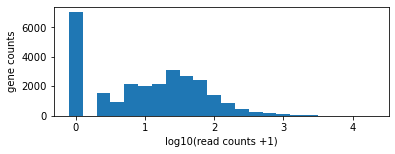

In [61]:
x, y = get_read_per_gene(pb_gene_count.values())

plt.figure(figsize=(6, 2))
plt.bar(x, y, width=0.2)
plt.xlabel('log10(read counts +1)')
plt.ylabel('gene counts')
plt.show()

## nanopore data

In [50]:
%%time
nano_bam_path = '/public/home/mowp/test/nanopore_cdna/full_length_transcripts/fhh.full_length.sorted.bam'
nano_gene_count = gene_count(nano_bam_path)

CPU times: user 1min 1s, sys: 1.53 s, total: 1min 3s
Wall time: 1min 3s


mapping to protein coding gene: 77.95%


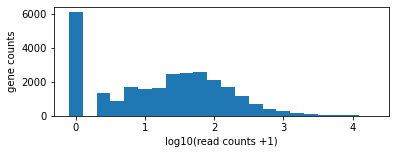

In [62]:
x, y = get_read_per_gene(nano_gene_count.values())

plt.figure(figsize=(6, 2))
plt.bar(x, y, width=0.2)
plt.xlabel('log10(read counts +1)')
plt.ylabel('gene counts')
plt.show()

# mapped read length distribution

In [93]:
def get_read_length_from_fastq(read_path):
    read_len = []
    with gzip.open(read_path, 'rt') as f:
        for read in SeqIO.parse(f, 'fastq'):
            read_len.append(len(read.seq))
    return np.array(read_len)

In [146]:
def get_read_length_from_bam(bam_path):
    read_len = []
    with pysam.AlignmentFile(bam_path, 'rb') as bam:
        for read in bam:
            if not read.is_unmapped:
                for read in bam:
                    read_len.append(read.query_length)
    return np.array(read_len)

## pacbio data

### pacbio raw read length

In [153]:
# pacbio mapped read length
pb_read_path = '/public/home/mowp/data/pacbio_cdna/aligned_data/isoseq.tagged.mm2.sorted.bam'
pb_raw_read_length = get_read_length_from_bam(pb_read_path)
# save data
with open('pb_raw_read_length.npy', 'wb') as o:
    np.save(o, pb_raw_read_length)

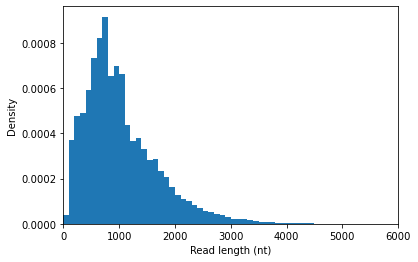

DescribeResult(nobs=1821580, minmax=(80, 8671), mean=1032.1265395974922, variance=441683.76543667336, skewness=1.393121498699833, kurtosis=3.0176829184772878)

In [154]:
xlim = 6000
bins = np.arange(0, xlim, 100)
plt.hist(pb_raw_read_length[pb_raw_read_length<=xlim], bins=bins, density=True)
plt.xlim(0, xlim)
plt.xlabel('Read length (nt)')
plt.ylabel('Density')
plt.show()
pb_raw_stats = stats.describe(pb_raw_read_length)
pb_raw_stats

### pacbio full length read

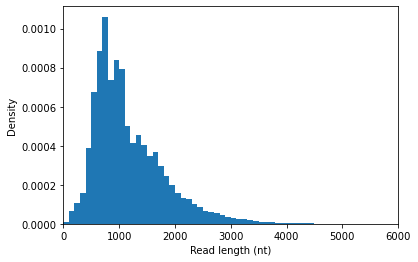

In [155]:
pb_fl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.full_length.sorted.bam'
pb_fl_read_length = get_read_length_from_bam(pb_fl_read_path)
# save data
with open('pb_fl_read_length.npy', 'wb') as o:
    np.save(o, pb_fl_read_length)

xlim = 6000
bins = np.arange(0, xlim, 100)
plt.hist(pb_fl_read_length[pb_fl_read_length<=xlim], bins=bins, density=True)
plt.xlim(0, xlim)
plt.xlabel('Read length (nt)')
plt.ylabel('Density')
plt.show()
pb_fl_stats = stats.describe(pb_fl_read_length)

## nanopore

### nanopore raw read length

In [147]:
# nanopore mappped read length
nano_read_path = '/public/home/mowp/test/nanopore_cdna/aligned_data/fhh.tagged.mm2.sorted.bam'
nano_raw_read_length = get_read_length_from_bam(nano_read_path)
# save data
with open('nano_raw_read_length.npy', 'wb') as o:
    np.save(o, nano_raw_read_length)

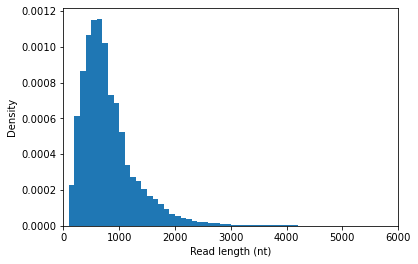

DescribeResult(nobs=5170233, minmax=(87, 13827), mean=808.8599386139852, variance=252721.18908369038, skewness=2.049637067756201, kurtosis=7.9052434035397265)

In [148]:
xlim = 6000
bins = np.arange(0, xlim, 100)
plt.hist(nano_raw_read_length[nano_raw_read_length<=xlim], bins=bins, density=True)
plt.xlim(0, xlim)
plt.xlabel('Read length (nt)')
plt.ylabel('Density')
plt.show()
nano_raw_stats = stats.describe(nano_raw_read_length)
nano_raw_stats

### nanopore full length read

In [149]:
nano_fl_read_path = '/public/home/mowp/test/nanopore_cdna/full_length_transcripts/fhh.full_length.sorted.bam'
nano_fl_read_length = get_read_length_from_bam(nano_fl_read_path)
# save data
with open('nano_fl_read_length.npy', 'wb') as o:
    np.save(o, pb_fl_read_length)

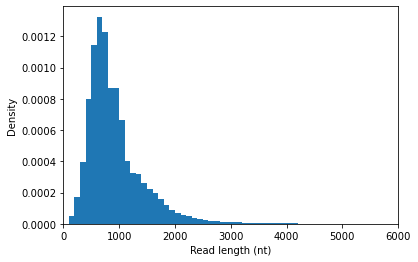

DescribeResult(nobs=3080340, minmax=(100, 13827), mean=923.0132099054, variance=257512.76255421125, skewness=2.066083133695734, kurtosis=7.8056464734518745)

In [150]:
xlim = 6000
bins = np.arange(0, xlim, 100)
plt.hist(nano_fl_read_length[nano_fl_read_length<=xlim], bins=bins, density=True)
plt.xlim(0, xlim)
plt.xlabel('Read length (nt)')
plt.ylabel('Density')
plt.show()
nano_fl_stats = stats.describe(nano_fl_read_length)
nano_fl_stats

### summary

length distribution of pacbio data

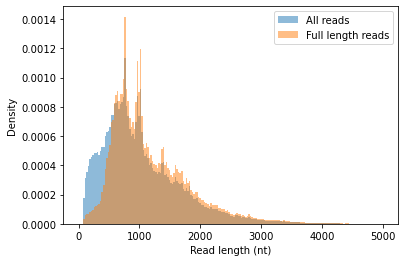

In [188]:
xlim = 5000
bins = np.linspace(0, xlim, 200)
plt.hist(pb_raw_read_length[pb_raw_read_length<=xlim], bins=bins, density=True, label='All reads', alpha=.5)
plt.hist(pb_fl_read_length[pb_fl_read_length<=xlim], bins=bins, density=True, label='Full length reads', alpha=.5)
plt.xlabel('Read length (nt)')
plt.ylabel('Density')
plt.legend()
plt.show()

length distribution of nanopore data

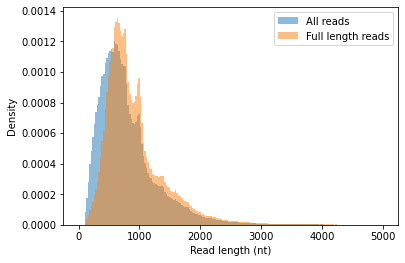

In [189]:
xlim = 5000
bins = np.linspace(0, xlim, 200)
plt.hist(nano_raw_read_length[nano_raw_read_length<=xlim], bins=bins, density=True, label='All reads', alpha=.5)
plt.hist(nano_fl_read_length[nano_fl_read_length<=xlim], bins=bins, density=True, label='Full length reads', alpha=.5)
plt.xlabel('Read length (nt)')
plt.ylabel('Density')
plt.legend()
plt.show()

**read length description**

In [157]:
pd.DataFrame(
    [pb_raw_stats, pb_fl_stats,
    nano_raw_stats, nano_fl_stats],
    index = ['pb_raw', 'pb_fl', 
            'nano_raw', 'nano_fl']
)

,nobs,minmax,mean,variance,skewness,kurtosis
pb_raw,1821580,"(80, 8671)",1032.126540,441683.765437,1.393121,3.017683
pb_fl,1186218,"(80, 8671)",1177.598197,419343.545223,1.453125,3.187851
nano_raw,5170233,"(87, 13827)",808.859939,252721.189084,2.049637,7.905243
nano_fl,3080340,"(100, 13827)",923.013210,257512.762554,2.066083,7.805646


# isoform length distributions

In [160]:
def sum_blockSizes(blockSizes):
    blockSizes = np.fromstring(blockSizes, dtype=int, sep=',')
    return sum(blockSizes)

## pacbio

In [158]:
pb_fl_isoform_path = '/public/home/mowp/data/pacbio_cdna/splicing_isoforms/isoseq.full_length_isoform.bed'
pb_fl_isoform = pd.read_csv(pb_fl_isoform_path, sep='\t', 
                            names=['chrom', 'chromStart', 'chromEnd', 'name', 
                                   'score', 'strand', 'thickStart', 'thickEnd', 
                                   'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'])

In [166]:
pb_isoform_len = pb_fl_isoform['blockSizes'].map(sum_blockSizes)

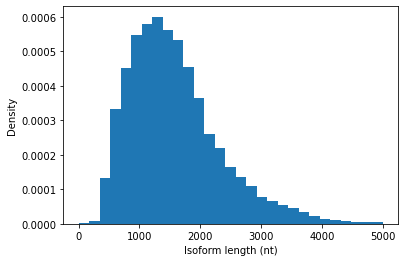

In [175]:
xlim = 5000
bins = np.linspace(0, xlim, 30)
plt.hist(pb_isoform_len, bins=bins, density=True)
#plt.xlim(0, xlim)
plt.xlabel('Isoform length (nt)')
plt.ylabel('Density')
plt.show()

## nanopore

In [220]:
nano_fl_isoform_path = '/public/home/mowp/test/nanopore_cdna/splicing_isoforms/fhh.full_length_isoform.bed'
nano_fl_isoform = pd.read_csv(nano_fl_isoform_path, sep='\t', 
                              names=['chrom', 'chromStart', 'chromEnd', 'name', 
                                     'score', 'strand', 'thickStart', 'thickEnd', 
                                     'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'])

In [177]:
nano_isoform_len = nano_fl_isoform['blockSizes'].map(sum_blockSizes)

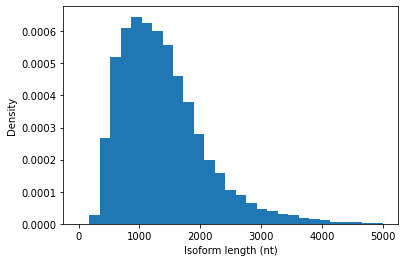

In [178]:
xlim = 5000
bins = np.linspace(0, xlim, 30)
plt.hist(nano_isoform_len, bins=bins, density=True)
#plt.xlim(0, xlim)
plt.xlabel('Isoform length (nt)')
plt.ylabel('Density')
plt.show()

## summary

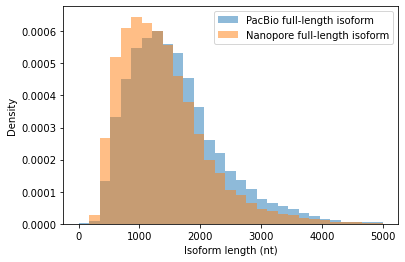

In [207]:
xlim = 5000
bins = np.linspace(0, xlim, 30)
plt.hist(pb_isoform_len, bins=bins, density=True, label='PacBio full-length isoform', alpha=.5)
plt.hist(nano_isoform_len, bins=bins, density=True, label='Nanopore full-length isoform', alpha=.5)
plt.xlabel('Isoform length (nt)')
plt.ylabel('Density')
plt.legend()
plt.show()

**isoform length description**

In [192]:
pd.DataFrame([pb_isoform_len.describe(), nano_isoform_len.describe()],
             index = ['pacbio', 'nanopore']
            )

,count,mean,std,min,25%,50%,75%,max
pacbio,23901.0,1585.611104,770.493029,84.0,1028.0,1457.0,1964.0,8389.0
nanopore,33251.0,1388.192115,712.017693,189.0,869.0,1262.0,1740.0,7400.0


为什么pacbio测的比nanopre长？

# genome view plot

先从bed文件获取gene model数据

In [226]:
araport11_isoform_path = '/public/home/mowp/test/nanopore_cdna/supplementary_data/get_representative_gene_model/araport11.representative.gene_model.bed'
araport11_isoform = pd.read_csv(araport11_isoform_path, sep='\t', 
                                names=['chrom', 'chromStart', 'chromEnd', 'name', 
                                       'score', 'strand', 'thickStart', 'thickEnd', 
                                       'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
                               )
araport11_isoform['gene_id'] = araport11_isoform['name'].map(lambda x: x.split('.')[0])
araport11_isoform = araport11_isoform.set_index('gene_id')

In [746]:
araport11_isoform

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
gene_id,,,,,,,,,,,,
AT1G01010,1,3630,5899,AT1G01010.1,0,+,3759,5630,0,6,"283,281,120,390,153,461,","0,365,855,1075,1543,1808,"
AT1G01020,1,6787,9130,AT1G01020.1,0,-,6914,8666,0,9,"282,76,67,86,74,46,90,48,560,","0,369,596,776,974,1154,1448,1629,1783,"
AT1G01030,1,11648,13714,AT1G01030.1,0,-,11863,12940,0,2,"1525,380,","0,1686,"
AT1G01040,1,23415,31120,AT1G01040.2,0,+,23518,31079,0,20,"1036,114,211,395,220,173,123,161,234,151,183,1...","0,1126,1336,1625,2108,2409,2665,2876,3127,3446..."
AT1G01046,1,28499,28706,AT1G01046.1,0,+,28634,28655,0,1,"21,","135,"
...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG09800,Mt,239951,240023,ATMG09800.1,0,-,239951,240023,0,1,"72,","0,"
ATMG09830,Mt,262130,262209,ATMG09830.1,0,-,262130,262209,0,1,"79,","0,"
ATMG09950,Mt,333650,333725,ATMG09950.1,0,-,333650,333725,0,1,"75,","0,"


In [235]:
araport11_isoform.loc['AT1G01046', 'chromStart']

28499

In [1078]:
class IGV:
    def __init__(self, gene_id, fl_bam=None, non_fl_bam=None):
        self.gene_id = gene_id
        self.fl_bam = fl_bam  # full length bam path
        self.non_fl_bam = non_fl_bam  # non full length bam path
        self.fl_bam_read = []  # a list consist of full length bam read
        self.non_fl_bam_read = []  # a list consist of non full length bam read
        self._get_gene_info()
        self.ypos = 1  # 画图的垂直位置
        self.xlim = [self.start, self.end]  # 画布水平边界
        
    def _get_gene_info(self):
        '''
        Get gene info from bed file
        '''
        gene_info = araport11_isoform.loc[self.gene_id]  # araport11_isoform loaded from pandas
        self.chrom = gene_info.chrom
        self.start = gene_info.chromStart
        self.end = gene_info.chromEnd
        self.strand = gene_info.strand
        self.blockSizes = np.fromstring(gene_info.blockSizes, sep=',')
        self.blockStarts = np.fromstring(gene_info.blockStarts, sep=',') + self.start # 0 base
    
    def get_gene_id_from_tags(self, tags):
        for tag, value in tags:
            if tag == 'gi':
                return value

    def _setup(self, ax):
        '''
        设置边
        '''
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_major_locator(ticker.NullLocator())
    
    def plot_gene_model(self, ax, start, end, strand, blockSizes, blockStarts):
        '''
        Visualize gene model from bed file

        Parms:
            @ypos: yaxis of the gene in the plot [int]
            @start: start position of the gene [int]
            @end: end position of the gene [int]
            @strand: strand od the gene ['+' or '-']
            @blockSizes: size of exons [array]
            @blockStarts: start position of gene [array]

        example:
            @ypos: 1
            @start: 6787
            @end: 9130
            @strand: '-'
            @blockSizes: array([282.,  76.,  67.,  86.,  74.,  46.,  90.,  48., 560.]),
            @blockStarts: array([6787., 7156., 7383., 7563., 7761., 7941., 8235., 8416., 8570.]))
        '''
        small_relative = 0.02 * (end-start)  # 箭头突出部分相对长度
        ax.plot([start, end], [self.ypos, self.ypos], color='darkblue')  # 基因有多长这条线就有多长
        height = .25 # gene model 高度
        for exonstart, size in zip(blockStarts, blockSizes):
            if exonstart == start and strand == '-':  # 负链的最后一个exon
                vertices = [(start, self.ypos), 
                            (start+small_relative, self.ypos+height), (exonstart+size, self.ypos+height), 
                            (exonstart+size, self.ypos-height), (start+small_relative, self.ypos-height)]
                exon = mp.Polygon(vertices, closed=True, fill=True, color='darkblue')  # 多边形箭头 ⬅
            elif exonstart+size == end and strand == '+':  # 正链的最后一个exon
                vertices = [(exonstart, self.ypos-height), (exonstart, self.ypos+height), 
                            (end-small_relative, self.ypos+height), 
                            (end, self.ypos), (end-small_relative, self.ypos-height)]
                exon = mp.Polygon(vertices, closed=True, fill=True, color='darkblue')  # 多边形箭头 →
            else:  # 普通exon，无箭头
                exon = mp.Rectangle((exonstart, self.ypos-height), size, height*2, color='darkblue', linewidth=0)
            ax.add_patch(exon)
            
        self.ypos += -1  # 空行画下一部分
        
    def plot_bam_read(self, ax, read_list):
        color = 'skyblue'  # bam read color
        for read in read_list:
            ax.plot([read.reference_start, read.reference_end], [self.ypos, self.ypos], color='grey', linewidth=0.5, alpha=.7)     
            for bloct_start, block_end in read.get_blocks():
                ax.plot([bloct_start, block_end], [self.ypos, self.ypos], color=color, linewidth=1)
            self.ypos += -.1
    
    def bam_fetch(self, bam_file, read_list):
        '''
        预读入数据，将read数据导入read_list
        '''
        with pysam.AlignmentFile(bam_file, 'rb') as bam:
            for read in bam.fetch(self.chrom, self.start, self.end):
                if get_gene_id_from_tags(read.get_tags()) == self.gene_id:
                    read_list.append(read)
                    self.xlim[0] = min(self.xlim[0], read.reference_start)
                    self.xlim[1] = max(self.xlim[1], read.reference_end)
                    
            # TODO 如果需要排序
            # read_list.sort(key=lambda read: read.query_alignment_length, reverse=True) 
                    
    def genomeview(self):
        '''
        可视化画图:
            先画gene model -> plot_gene_model
            再画bam文件 -> plot_bam_read
            如果是负链，则水平翻转，使所有基因为同一方向
        '''
        
        '''
        Fetching bam data!
        '''
        if self.fl_bam is not None:
            self.bam_fetch(self.fl_bam, self.fl_bam_read)
        if self.non_fl_bam is not None:
            self.bam_fetch(self.non_fl_bam, self.non_fl_bam_read)
        '''
        Start plotting!
        '''
        ysize = len(self.fl_bam_read) + len(self.non_fl_bam_read)
        annx = (self.start+self.end)/2
        fig, ax = plt.subplots(figsize=(6, 1+ysize*.05))
        # plot geng model
        ax.annotate(s=self.gene_id,
                    xy=(annx, self.ypos+.5), ha='center')
        self.plot_gene_model(ax, self.start, self.end, self.strand, self.blockSizes, self.blockStarts)
        
        # plot bam reads
        if self.fl_bam is not None:
            ax.annotate(s='full-length reads',
                        xy=(annx, self.ypos+.25), ha='center')
            self.plot_bam_read(ax, self.fl_bam_read)
            self.ypos += -.9  # 空行画下一部分
        if self.non_fl_bam is not None:
            ax.annotate(s='non-full-length reads',
                        xy=(annx, self.ypos+.25), ha='center')
            self.plot_bam_read(ax, self.non_fl_bam_read)
            # 😂 get full-length read has some bug!
        
        '''
        Set axis!
        '''
        self._setup(ax)
        step = (self.end-self.start)//400*100
        
        if self.strand == '+':
            xticks = np.arange(self.start, self.end+step, step)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks-self.start)
            ax.set_xlim(self.xlim[0], self.xlim[1])
        else:
            # 如果为负链，将方向反过来
            xticks = np.arange(self.end, self.start-step, -step)
            ax.set_xticks(xticks)
            ax.set_xticklabels(self.end-xticks)
            ax.set_xlim(self.xlim[1], self.xlim[0])
        ax.set_xlabel('Length (nt)')

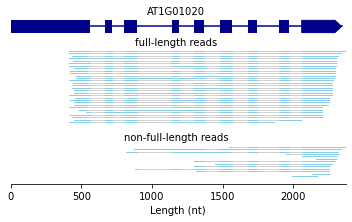

In [1079]:
pb_fl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.full_length.sorted.bam'
pb_nonfl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.non_full_length.sorted.bam'
igv = IGV('AT1G01020', pb_fl_read_path, pb_nonfl_read_path)
igv.genomeview()

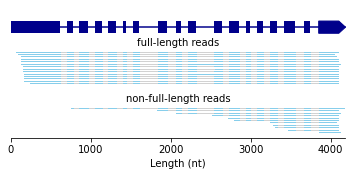

In [1080]:
pb_fl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.full_length.sorted.bam'
pb_nonfl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.non_full_length.sorted.bam'
igv = IGV('AT2G43400', pb_fl_read_path, pb_nonfl_read_path)
igv.genomeview()

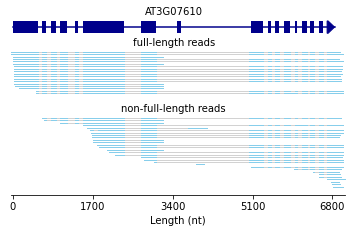

In [1081]:
# IBM1
pb_fl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.full_length.sorted.bam'
pb_nonfl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.non_full_length.sorted.bam'
igv = IGV('AT3G07610', pb_fl_read_path, pb_nonfl_read_path)
igv.genomeview()

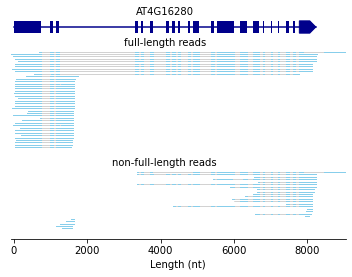

In [1082]:
# FCA
pb_fl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.full_length.sorted.bam'
pb_nonfl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.non_full_length.sorted.bam'
igv = IGV('AT4G16280', pb_fl_read_path, pb_nonfl_read_path)
igv.genomeview()